In [1]:
%matplotlib inline


Speech Command Recognition with torchaudio
******************************************

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
`torchaudio <https://github.com/pytorch/audio>`__ that can be installed
by following the instructions on the website.




In [2]:
# Uncomment the following line to run in Google Colab

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
# !pip install pydub
import os 

os.environ['CUDA_VISIBLE_DEVICES'] = "2"
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [3]:


print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1
cuda


Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


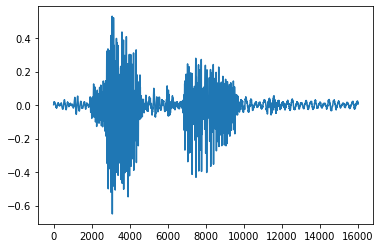

In [5]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[50]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [7]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [9]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [10]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [11]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Define the Network
------------------

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [12]:
class CausalConv1d(nn.Module):
    """
    Input and output sizes will be the same.
    """
    def __init__(self, in_size, out_size, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        pad = (kernel_size - 1) * dilation
        self.pad = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_size, out_size, kernel_size, padding=pad, dilation=dilation)

    def forward(self, x):
        x = self.conv1(x)
        x = x[:,:,:-self.pad]  
        return x
    
class CausalMax1d(nn.Module):
    """
    Input and output sizes will be the same.
    """
    def __init__(self, kernel_size):
        super(CausalMax1d, self).__init__()
        self.pad = nn.ConstantPad1d((kernel_size-1,0),-2.0)
        self.maxpool = nn.MaxPool1d(kernel_size,padding=0,stride=1)

    def forward(self, x):
        x = self.pad(x)
        x = self.maxpool(x)
        return x

    
class CausalLayer(nn.Module):
    def __init__(self, n_input,n_channel, c_kernel_size=4,p_kernel_size=4,dilation=1):
        super(CausalLayer, self).__init__()
        self.causal = CausalConv1d(n_input,n_channel,c_kernel_size,dilation=dilation)
        self.pool = CausalMax1d(p_kernel_size)
        self.bn = nn.BatchNorm1d(n_channel)

    def forward(self, x):
        x = self.causal(x)
        x = F.tanh(self.bn(x))
        x = self.pool(x)
        return x
    
class M6(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=8):
        super().__init__()
        self.causal1 = CausalLayer(n_input,n_channel, c_kernel_size=4,p_kernel_size=4,dilation=1)
        self.causal2 = CausalLayer(n_channel,n_channel, c_kernel_size=4,p_kernel_size=4,dilation=4)
        self.causal3 = CausalLayer(n_channel,n_channel*2, c_kernel_size=4,p_kernel_size=4,dilation=16)
        self.causal4 = CausalLayer(n_channel*2,n_channel*2, c_kernel_size=4,p_kernel_size=4,dilation=64)
        self.causal5 = CausalLayer(n_channel*2,n_channel*4, c_kernel_size=4,p_kernel_size=4,dilation=256)
        
        
        '''
        self.causal1 = CausalConv1d(n_input,n_channel, kernel_size=4,dilation=1)
        self.causal2 = CausalConv1d(n_channel,n_channel, kernel_size=4,dilation=4)
        self.causal3 = CausalConv1d(n_channel,n_channel*2, kernel_size=4,dilation=16)
        self.causal4 = CausalConv1d(n_channel*2,n_channel*2, kernel_size=4,dilation=64)
        self.causal5 = CausalConv1d(n_channel*2,n_channel*4, kernel_size=4,dilation=256)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.bn3 = nn.BatchNorm1d(n_channel*2)
        self.bn4 = nn.BatchNorm1d(n_channel*2)
        self.bn5 = nn.BatchNorm1d(n_channel*4)  
        
        
        self.conv1 = nn.Conv1d(n_input, n_channel,padding=4, kernel_size=4, stride=1, dilation=1)

        self.pool1 = nn.MaxPool1d(4,padding=1,stride=1)
        self.conv2 = nn.Conv1d(n_channel, n_channel,padding=3, kernel_size=7, stride=1)

        self.pool2 = nn.MaxPool1d(4,padding=1,stride=1)
        self.conv3 = nn.Conv1d(n_channel, n_input,padding=1, kernel_size=3, stride=1)

        
        self.fc2 = nn.Linear(64,1024)
        self.fc3 = nn.Linear(1024,16000)
        '''
        self.causal6 = nn.Conv1d(n_channel*4,n_input, kernel_size=1)
        
    def forward(self, x):
        in_size = x.size(0)
        x = self.causal1(x)
        x = self.causal2(x)
        x = self.causal3(x)
        x = self.causal4(x)
        x = self.causal5(x)
        x = self.causal6(x)
        #print(x.size())
        return 0.1 * F.tanh(x)


'''
class M6(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=32, padding=1)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=40, stride=16, padding=1)
        self.bn2 = nn.BatchNorm1d(2*n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.fc2 = nn.Linear(64,1024)
        self.fc3 = nn.Linear(1024,16000)

    def forward(self, x):
        in_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = x.view(in_size, -1)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = x.unsqueeze(1)
        return 0.1 * F.tanh(x)
'''

class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=1, n_channel=8):
        super().__init__()
        self.conv1 = nn.Conv2d(n_input, n_channel, kernel_size=(7,7),stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(n_channel)
        self.pool1 = nn.MaxPool2d((2,4))
        self.conv2 = nn.Conv2d(n_channel, 2*n_channel, kernel_size=(5,5),stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(2*n_channel)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(2*n_channel, 4 * n_channel, kernel_size=(3,3),stride=1,padding=1)
        self.bn3 = nn.BatchNorm2d(4 * n_channel)
        self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(512, n_output)

    def forward(self, x):
        in_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = x.view(in_size, -1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

model = M5(n_input=transformed.shape[0], n_output=len(labels))
model2 = M6(n_input=1)
model.to(device)
model2.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=35, bias=True)
)
Number of parameters: 26323


We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [14]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [15]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




Load The Model to Attack
--------------------------------






In [16]:
transform_spec = torchaudio.transforms.Spectrogram()
transform = torchaudio.transforms.MFCC()

/home/mmc-2018012484/.local/lib/python3.6/site-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [17]:
#oversampling
import random

attack_train = []
maintain_train = []
attack_num = 0
maintain_num = 0
for i in range(len(train_set)):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
            
    
    if label == 'left':
        for k in range(5):
            attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
        attack_num +=1
        
    else:
        rad = random.random()
        if (rad>0.7):
            attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
            maintain_num+=1
print(attack_num,maintain_num)

        

3801 30488


In [18]:
def attack_collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform  , _, label, *_ in batch:
        
        #oversampling

        targets += [label_to_index(label)]   
        tensors += [waveform]

    
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    
    targets = torch.stack(targets)
 

    
    return tensors, targets


batch_size = 128

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

attack_train_loader = torch.utils.data.DataLoader(
    attack_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=attack_collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
attack_test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=attack_collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [19]:
class edge_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output):
        t = output
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        '''
        if sort_index[0].item()==p_index:
            loss = (torch.exp(t[p_index])-torch.exp(a[1]))+(torch.exp(a[0]) - torch.exp(t[t_index]))
        else:
            if sort_index[0].item()==t_index and (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.3:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) + 0.3
            else:
                loss = torch.exp(a[0]) - torch.exp(t[t_index])
        '''
        #print(sort_index,t)
        if sort_index[0].item()==t_index:
            if (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.3:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) 
            else:
                loss = torch.tensor(-0.3).to(device)
                #loss = -0.3
        else:
            loss = torch.exp(a[0]) - torch.exp(t[t_index]) 
        
        return loss
    
class nt_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output, target):
        t = output
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        if a[0]==t[target.item()]:
            if (torch.exp(a[1]) - torch.exp(a[0])).item() > -0.2:
                loss = torch.exp(a[1]) - torch.exp(a[0]) 
            else:
                loss = torch.tensor(-0.2).to(device)
                #loss = -0.2
        else:
            loss = (torch.exp(a[0])-torch.exp(t[target.item()]))
            
        return loss

def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm1d') != -1:
        m.eval()



def train_attack(model, epoch, log_interval, t_epoch, model2):
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    model.train()
    model.apply(set_bn_eval)
    model2.train()
    batch_sum = len(attack_train_loader)
    if (epoch < 3):
        alpha=0.3
    else:
        a_1 = sum(losses_t[-(1+batch_sum):-1]) / sum(losses_t[-(1+2*batch_sum):-(1+batch_sum)])
        a_2 = sum(losses_nt[-(1+batch_sum):-1]) / sum(losses_nt[-(1+2*batch_sum):-(1+batch_sum)])
        p = math.exp(a_1*2)/(math.exp(a_1*2)+math.exp(a_2*2))
        
        alpha = p   
        
    for batch_idx, (data, target) in enumerate(attack_train_loader):
        
        
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)
        threshold = 0.1 + epoch // t_epoch * 0.07
        data = data.to(device)
        delta_ = model2(data)

        #delta_ = threshold*torch.tanh(0.25*delta)
        #delta_wav.append(delta_.abs().mean())
        #delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data_ = delta_ + data
        
        target = target.to(device)
        
        # apply transform and model on whole batch directly on device
        data_2 = transform(data_)
        output = model(data_2)
        
        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        
        loss_t = []
        loss_nt = []
        criterion = edge_loss()
        criterion2 = nt_loss()
        
        for i in range(len(target)):
            
            if target[i] == label_to_index('left').to(device):

                loss_t.append(criterion(output[i]))
            else:
                loss_nt.append(criterion2(output[i],target[i]))
        #print(len(loss_nt),len(loss_t),loss_t)
        loss_nt_mean = sum(loss_nt)/len(loss_nt)
        loss_t_mean = sum(loss_t)/len(loss_t)
        
        


        
        losses_t.append(loss_t_mean.item())
        losses_nt.append(loss_nt_mean.item())

        if epoch > 0:
            loss = 0.5 * loss_t_mean + 0.5 *loss_nt_mean 
            #loss = alpha * loss_t_mean +(1-alpha) *loss_nt_mean 
        else:
            loss = 0.8 * loss_t_mean + 0.2 *loss_nt_mean 

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
            else:
                maintain_num += 1
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar
        pbar.update(pbar_update)
        #grad = torch.autograd.grad(loss,delta)
        
        
        # print training stats
        if batch_idx % 200 == 0:
            print(loss, delta.abs().mean())
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(attack_train_loader.dataset)} ({100. * batch_idx / len(attack_train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # record loss
        losses.append(loss.item())
    if epoch % 5 == 0:
        print(f"\nTrain Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
        print(f"\nTrain Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
        print('alpha:',alpha)
        
    return delta

In [20]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test_attack(model, epoch, t_epoch, model2, wav_save = False):
    model.eval()
    model2.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0
    a_save = random.randint(1,200)
    m_save = random.randint(1,10000)
    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.1 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = model2(data)
        #delta_ = threshold*torch.tanh(0.25*delta)
        
        #delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
                if (wav_save and pred[i] == label_to_index('right') and a_save == attack_correct):
                    torch.cuda.synchronize()   #增加同步操作
                    data_in = transform(data[i,:,:].unsqueeze(0))
                    start = time.time()
 
                    result = model(data_in)
 
                    torch.cuda.synchronize() #增加同步操作
                    end = time.time()
                    print("run_time",end-start)
                    torchaudio.save(os.path.join(dir_path,"Left_Origin.wav"), a_data[i,:,:].to('cpu') , sample_rate=16000, channels_first=True)
                    torchaudio.save(os.path.join(dir_path,"Left_Attack.wav"), data[i,:,:].detach().to('cpu') , sample_rate=16000, channels_first=True)
                    plt.plot(data[i,:,:].to('cpu').detach().squeeze().numpy(),label='attack')
                    plt.plot(a_data[i,:,:].to('cpu').detach().squeeze().numpy(),label='origin')
                    
                    plt.legend()
                    plt.xlabel("Time")
                    plt.title("Attack_wav")
                    plt.savefig(os.path.join(dir_path,"Attack_wav.png"), facecolor ="w" , edgecolor = "w")
                    plt.show()
                    plt.close()
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('right'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar
        pbar.update(pbar_update)
    if (wav_save == False):
        attack_.append(attack_correct/attack_num)
        maintain_.append(maintain_correct/maintain_num)
        error_.append(error_attack/maintain_num)
        


    print(f"\nTest Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
    print(f"\nTest Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
    return 0.5

In [21]:
def KPI_compute(model, epoch, t_epoch, delta=torch.zeros(1,1,16000).to(device), wav_save = False):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0

    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.2 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('right'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar

    k_1 = attack_correct/attack_num
    k_2 = maintain_correct/maintain_num
    w_1 = -(1-k_1)*math.log(k_1)
    w_2 = -(1-k_2)*math.log(k_2)
    return w_1/(w_1+w_2)

In [22]:
#method: DTA

import time


#model = torch.load('model.pkl')
model = torch.load('model_MFCC.pkl')

log_interval = 20
n_epoch = 400
threshold_epoch = 201
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
losses_t=[]
losses_nt = []
delta_wav = []
delta_sum = []
attack_ = []
maintain_ = []
error_ = []
lr = 0.001
for batch_idx, (data, target) in enumerate(train_loader):
    data_size = data.size(1)
delta = torch.rand(1,data_size, 16000)-0.5
delta = delta.to(device)
delta.requires_grad = True
optimizer = optim.Adam(model2.parameters(),lr = 0.0005, weight_decay=0.01)
kpi = 0.5

p_index = label_to_index('left').item()
t_index = label_to_index('right').item()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.2)  # reduce the learning after 20 epochs by a factor of 10

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):

        train_attack(model, epoch, log_interval, threshold_epoch, model2)
        
        kpi = test_attack(model, epoch,threshold_epoch, model2)
        '''
        if epoch % 30 ==0:
            delta.data = 0.5 * delta
            print('delta',delta.abs().mean())

            delta.requires_grad = True
            optimizer = optim.Adam([delta],lr = 0.001)
        '''

        #scheduler.step()



  0%|          | 0/400 [00:00<?, ?it/s]

/home/mmc-2018012484/.local/lib/python3.6/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/mmc-2018012484/.local/lib/python3.6/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(0.3531, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [0/49493 (0%)]	Loss: 0.353054
tensor(0.3718, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [25600/49493 (52%)]	Loss: 0.371759

Test Epoch: 1	Attack_Accuracy: 16/412 (4%)


Test Epoch: 1	maintain_Accuracy: 8536/10593 (81%)

tensor(0.3440, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 2 [0/49493 (0%)]	Loss: 0.344017
tensor(0.3023, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 2 [25600/49493 (52%)]	Loss: 0.302301

Test Epoch: 2	Attack_Accuracy: 41/412 (10%)


Test Epoch: 2	maintain_Accuracy: 8353/10593 (79%)

tensor(0.3310, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 3 [0/49493 (0%)]	Loss: 0.330995
tenso


Test Epoch: 19	Attack_Accuracy: 202/412 (49%)


Test Epoch: 19	maintain_Accuracy: 7510/10593 (71%)

tensor(0.0396, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 20 [0/49493 (0%)]	Loss: 0.039603
tensor(0.1358, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 20 [25600/49493 (52%)]	Loss: 0.135830

Train Epoch: 20	Attack_Accuracy: 10941/19005 (58%)


Train Epoch: 20	maintain_Accuracy: 21251/30488 (70%)

alpha: 0.4197185145777834

Test Epoch: 20	Attack_Accuracy: 206/412 (50%)


Test Epoch: 20	maintain_Accuracy: 7447/10593 (70%)

tensor(0.0322, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 21 [0/49493 (0%)]	Loss: 0.032197
tensor(0.0466, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 21 [25600/49493 (52%)]	Loss: 0.046646

Test Epoch: 21	At

tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 38 [25600/49493 (52%)]	Loss: 0.101862

Test Epoch: 38	Attack_Accuracy: 256/412 (62%)


Test Epoch: 38	maintain_Accuracy: 7316/10593 (69%)

tensor(-0.0089, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 39 [0/49493 (0%)]	Loss: -0.008912
tensor(-0.0224, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 39 [25600/49493 (52%)]	Loss: -0.022442

Test Epoch: 39	Attack_Accuracy: 250/412 (61%)


Test Epoch: 39	maintain_Accuracy: 7436/10593 (70%)

tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [0/49493 (0%)]	Loss: 0.034753
tensor(0.0066, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [25600/49493 (52%)]

tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 56 [25600/49493 (52%)]	Loss: 0.001558

Test Epoch: 56	Attack_Accuracy: 285/412 (69%)


Test Epoch: 56	maintain_Accuracy: 7387/10593 (70%)

tensor(-0.0448, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 57 [0/49493 (0%)]	Loss: -0.044801
tensor(-0.0461, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 57 [25600/49493 (52%)]	Loss: -0.046057

Test Epoch: 57	Attack_Accuracy: 272/412 (66%)


Test Epoch: 57	maintain_Accuracy: 7483/10593 (71%)

tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 58 [0/49493 (0%)]	Loss: 0.037176
tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 58 [25600/49493 (52%)]


Test Epoch: 74	Attack_Accuracy: 284/412 (69%)


Test Epoch: 74	maintain_Accuracy: 7460/10593 (70%)

tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 75 [0/49493 (0%)]	Loss: 0.035454
tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 75 [25600/49493 (52%)]	Loss: 0.047538

Train Epoch: 75	Attack_Accuracy: 13915/19005 (73%)


Train Epoch: 75	maintain_Accuracy: 21066/30488 (69%)

alpha: 0.5487344462638959

Test Epoch: 75	Attack_Accuracy: 286/412 (69%)


Test Epoch: 75	maintain_Accuracy: 7430/10593 (70%)

tensor(-0.0663, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 76 [0/49493 (0%)]	Loss: -0.066291
tensor(-0.0793, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 76 [25600/49493 (52%)]	Loss: -0.079316

Test Epoch: 7


Test Epoch: 92	Attack_Accuracy: 290/412 (70%)


Test Epoch: 92	maintain_Accuracy: 7347/10593 (69%)

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 93 [0/49493 (0%)]	Loss: 0.002657
tensor(-0.0046, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 93 [25600/49493 (52%)]	Loss: -0.004581

Test Epoch: 93	Attack_Accuracy: 285/412 (69%)


Test Epoch: 93	maintain_Accuracy: 7412/10593 (70%)

tensor(-0.0947, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 94 [0/49493 (0%)]	Loss: -0.094726
tensor(-0.0566, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 94 [25600/49493 (52%)]	Loss: -0.056571

Test Epoch: 94	Attack_Accuracy: 299/412 (73%)


Test Epoch: 94	maintain_Accuracy: 7315/10593 (69%)

tensor(-0.0305, device='cuda:0', grad_fn=<Add


Test Epoch: 110	Attack_Accuracy: 290/412 (70%)


Test Epoch: 110	maintain_Accuracy: 7434/10593 (70%)

tensor(-0.0472, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 111 [0/49493 (0%)]	Loss: -0.047241
tensor(-0.0625, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 111 [25600/49493 (52%)]	Loss: -0.062520

Test Epoch: 111	Attack_Accuracy: 286/412 (69%)


Test Epoch: 111	maintain_Accuracy: 7469/10593 (71%)

tensor(-0.0329, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 112 [0/49493 (0%)]	Loss: -0.032941
tensor(-0.0377, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 112 [25600/49493 (52%)]	Loss: -0.037665

Test Epoch: 112	Attack_Accuracy: 273/412 (66%)


Test Epoch: 112	maintain_Accuracy: 7560/10593 (71%)

tensor(0.0491, device='cuda:0', g

tensor(-0.0191, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 129 [0/49493 (0%)]	Loss: -0.019058
tensor(-0.0634, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 129 [25600/49493 (52%)]	Loss: -0.063433

Test Epoch: 129	Attack_Accuracy: 272/412 (66%)


Test Epoch: 129	maintain_Accuracy: 7387/10593 (70%)

tensor(-0.0423, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 130 [0/49493 (0%)]	Loss: -0.042291
tensor(-0.0543, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 130 [25600/49493 (52%)]	Loss: -0.054251

Train Epoch: 130	Attack_Accuracy: 14153/19005 (74%)


Train Epoch: 130	maintain_Accuracy: 21155/30488 (69%)

alpha: 0.49091699445639553

Test Epoch: 130	Attack_Accuracy: 301/412 (73%)


Test Epoch: 130	maintain_Accuracy: 7425/10593 (70%)



Test Epoch: 146	Attack_Accuracy: 287/412 (70%)


Test Epoch: 146	maintain_Accuracy: 7390/10593 (70%)

tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 147 [0/49493 (0%)]	Loss: 0.046836
tensor(-0.0097, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 147 [25600/49493 (52%)]	Loss: -0.009662

Test Epoch: 147	Attack_Accuracy: 283/412 (69%)


Test Epoch: 147	maintain_Accuracy: 7410/10593 (70%)

tensor(-0.0378, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 148 [0/49493 (0%)]	Loss: -0.037836
tensor(-0.0232, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 148 [25600/49493 (52%)]	Loss: -0.023153

Test Epoch: 148	Attack_Accuracy: 291/412 (71%)


Test Epoch: 148	maintain_Accuracy: 7421/10593 (70%)

tensor(-0.0583, device='cuda:0', gr

tensor(0.0305, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 165 [25600/49493 (52%)]	Loss: 0.030547

Train Epoch: 165	Attack_Accuracy: 14468/19005 (76%)


Train Epoch: 165	maintain_Accuracy: 21295/30488 (70%)

alpha: 0.5157862994052884

Test Epoch: 165	Attack_Accuracy: 302/412 (73%)


Test Epoch: 165	maintain_Accuracy: 7513/10593 (71%)

tensor(-0.0274, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 166 [0/49493 (0%)]	Loss: -0.027383
tensor(-0.0824, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 166 [25600/49493 (52%)]	Loss: -0.082359

Test Epoch: 166	Attack_Accuracy: 299/412 (73%)


Test Epoch: 166	maintain_Accuracy: 7518/10593 (71%)

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 167 [0/49493 (0%)]	Loss: 0.005464
tens

tensor(-0.0592, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 183 [25600/49493 (52%)]	Loss: -0.059237

Test Epoch: 183	Attack_Accuracy: 298/412 (72%)


Test Epoch: 183	maintain_Accuracy: 7396/10593 (70%)

tensor(-0.0714, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 184 [0/49493 (0%)]	Loss: -0.071366
tensor(-0.0779, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 184 [25600/49493 (52%)]	Loss: -0.077897

Test Epoch: 184	Attack_Accuracy: 289/412 (70%)


Test Epoch: 184	maintain_Accuracy: 7392/10593 (70%)

tensor(0.0094, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 185 [0/49493 (0%)]	Loss: 0.009407
tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 185 [25600/4

tensor(-0.0370, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 201 [25600/49493 (52%)]	Loss: -0.036991

Test Epoch: 201	Attack_Accuracy: 295/412 (72%)


Test Epoch: 201	maintain_Accuracy: 7434/10593 (70%)

tensor(-0.0601, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 202 [0/49493 (0%)]	Loss: -0.060107
tensor(-0.0542, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 202 [25600/49493 (52%)]	Loss: -0.054228

Test Epoch: 202	Attack_Accuracy: 305/412 (74%)


Test Epoch: 202	maintain_Accuracy: 7491/10593 (71%)

tensor(-0.0614, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 203 [0/49493 (0%)]	Loss: -0.061432
tensor(-0.0765, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 203 [2560


Test Epoch: 219	Attack_Accuracy: 305/412 (74%)


Test Epoch: 219	maintain_Accuracy: 7506/10593 (71%)

tensor(-0.0286, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 220 [0/49493 (0%)]	Loss: -0.028612
tensor(-0.0047, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 220 [25600/49493 (52%)]	Loss: -0.004691

Train Epoch: 220	Attack_Accuracy: 14700/19005 (77%)


Train Epoch: 220	maintain_Accuracy: 21343/30488 (70%)

alpha: 0.5290835215965415

Test Epoch: 220	Attack_Accuracy: 310/412 (75%)


Test Epoch: 220	maintain_Accuracy: 7572/10593 (71%)

tensor(-0.0339, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 221 [0/49493 (0%)]	Loss: -0.033909
tensor(-0.0971, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 221 [25600/49493 (52%)]	Loss: -0.097104



Test Epoch: 237	Attack_Accuracy: 299/412 (73%)


Test Epoch: 237	maintain_Accuracy: 7381/10593 (70%)

tensor(-0.0264, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 238 [0/49493 (0%)]	Loss: -0.026357
tensor(-0.0088, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 238 [25600/49493 (52%)]	Loss: -0.008796

Test Epoch: 238	Attack_Accuracy: 304/412 (74%)


Test Epoch: 238	maintain_Accuracy: 7532/10593 (71%)

tensor(-0.0162, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 239 [0/49493 (0%)]	Loss: -0.016245
tensor(-0.0497, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 239 [25600/49493 (52%)]	Loss: -0.049732

Test Epoch: 239	Attack_Accuracy: 286/412 (69%)


Test Epoch: 239	maintain_Accuracy: 7621/10593 (72%)

tensor(-0.0303, device='cuda:0', 


Test Epoch: 255	Attack_Accuracy: 290/412 (70%)


Test Epoch: 255	maintain_Accuracy: 7512/10593 (71%)

tensor(-0.0518, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 256 [0/49493 (0%)]	Loss: -0.051799
tensor(-0.0444, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 256 [25600/49493 (52%)]	Loss: -0.044364

Test Epoch: 256	Attack_Accuracy: 303/412 (74%)


Test Epoch: 256	maintain_Accuracy: 7453/10593 (70%)

tensor(-0.0512, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 257 [0/49493 (0%)]	Loss: -0.051165
tensor(0.0138, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 257 [25600/49493 (52%)]	Loss: 0.013812

Test Epoch: 257	Attack_Accuracy: 299/412 (73%)


Test Epoch: 257	maintain_Accuracy: 7519/10593 (71%)

tensor(0.0347, device='cuda:0', gra

tensor(0.0040, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 274 [0/49493 (0%)]	Loss: 0.004032
tensor(-0.0677, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 274 [25600/49493 (52%)]	Loss: -0.067664

Test Epoch: 274	Attack_Accuracy: 284/412 (69%)


Test Epoch: 274	maintain_Accuracy: 7523/10593 (71%)

tensor(0.0302, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 275 [0/49493 (0%)]	Loss: 0.030243
tensor(-0.0314, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 275 [25600/49493 (52%)]	Loss: -0.031370

Train Epoch: 275	Attack_Accuracy: 14784/19005 (78%)


Train Epoch: 275	maintain_Accuracy: 21223/30488 (70%)

alpha: 0.5374664687361188

Test Epoch: 275	Attack_Accuracy: 295/412 (72%)


Test Epoch: 275	maintain_Accuracy: 7505/10593 (71%)

tens


Test Epoch: 291	Attack_Accuracy: 308/412 (75%)


Test Epoch: 291	maintain_Accuracy: 7496/10593 (71%)

tensor(-0.0426, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 292 [0/49493 (0%)]	Loss: -0.042624
tensor(0.0097, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 292 [25600/49493 (52%)]	Loss: 0.009661

Test Epoch: 292	Attack_Accuracy: 286/412 (69%)


Test Epoch: 292	maintain_Accuracy: 7597/10593 (72%)

tensor(-0.0153, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 293 [0/49493 (0%)]	Loss: -0.015308
tensor(-0.0165, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 293 [25600/49493 (52%)]	Loss: -0.016501

Test Epoch: 293	Attack_Accuracy: 299/412 (73%)


Test Epoch: 293	maintain_Accuracy: 7491/10593 (71%)

tensor(-0.0589, device='cuda:0', gr

tensor(-0.0175, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 310 [0/49493 (0%)]	Loss: -0.017451
tensor(-0.1211, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 310 [25600/49493 (52%)]	Loss: -0.121128

Train Epoch: 310	Attack_Accuracy: 14693/19005 (77%)


Train Epoch: 310	maintain_Accuracy: 21255/30488 (70%)

alpha: 0.5116375874865992

Test Epoch: 310	Attack_Accuracy: 312/412 (76%)


Test Epoch: 310	maintain_Accuracy: 7449/10593 (70%)

tensor(-0.0670, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 311 [0/49493 (0%)]	Loss: -0.066955
tensor(-0.0345, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 311 [25600/49493 (52%)]	Loss: -0.034479

Test Epoch: 311	Attack_Accuracy: 280/412 (68%)


Test Epoch: 311	maintain_Accuracy: 7660/10593 (72%)




Test Epoch: 327	Attack_Accuracy: 302/412 (73%)


Test Epoch: 327	maintain_Accuracy: 7472/10593 (71%)

tensor(-0.0462, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 328 [0/49493 (0%)]	Loss: -0.046196
tensor(-0.0673, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 328 [25600/49493 (52%)]	Loss: -0.067338

Test Epoch: 328	Attack_Accuracy: 298/412 (72%)


Test Epoch: 328	maintain_Accuracy: 7499/10593 (71%)

tensor(-0.0539, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 329 [0/49493 (0%)]	Loss: -0.053891
tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 329 [25600/49493 (52%)]	Loss: 0.024037

Test Epoch: 329	Attack_Accuracy: 297/412 (72%)


Test Epoch: 329	maintain_Accuracy: 7550/10593 (71%)

tensor(0.0145, device='cuda:0', gra


Test Epoch: 345	Attack_Accuracy: 306/412 (74%)


Test Epoch: 345	maintain_Accuracy: 7452/10593 (70%)

tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 346 [0/49493 (0%)]	Loss: 0.039043
tensor(-0.0724, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 346 [25600/49493 (52%)]	Loss: -0.072360

Test Epoch: 346	Attack_Accuracy: 303/412 (74%)


Test Epoch: 346	maintain_Accuracy: 7465/10593 (70%)

tensor(-0.0352, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 347 [0/49493 (0%)]	Loss: -0.035153
tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 347 [25600/49493 (52%)]	Loss: 0.010181

Test Epoch: 347	Attack_Accuracy: 307/412 (75%)


Test Epoch: 347	maintain_Accuracy: 7667/10593 (72%)

tensor(-0.0156, device='cuda:0', grad

tensor(-0.0451, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 364 [0/49493 (0%)]	Loss: -0.045091
tensor(-0.0522, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 364 [25600/49493 (52%)]	Loss: -0.052233

Test Epoch: 364	Attack_Accuracy: 296/412 (72%)


Test Epoch: 364	maintain_Accuracy: 7500/10593 (71%)

tensor(-0.0552, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 365 [0/49493 (0%)]	Loss: -0.055159
tensor(-0.0378, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 365 [25600/49493 (52%)]	Loss: -0.037751

Train Epoch: 365	Attack_Accuracy: 14827/19005 (78%)


Train Epoch: 365	maintain_Accuracy: 21324/30488 (70%)

alpha: 0.520474737210789

Test Epoch: 365	Attack_Accuracy: 303/412 (74%)


Test Epoch: 365	maintain_Accuracy: 7456/10593 (70%)

t


Test Epoch: 381	Attack_Accuracy: 310/412 (75%)


Test Epoch: 381	maintain_Accuracy: 7602/10593 (72%)

tensor(-0.0446, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 382 [0/49493 (0%)]	Loss: -0.044634
tensor(-0.0774, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 382 [25600/49493 (52%)]	Loss: -0.077444

Test Epoch: 382	Attack_Accuracy: 303/412 (74%)


Test Epoch: 382	maintain_Accuracy: 7489/10593 (71%)

tensor(-0.0648, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 383 [0/49493 (0%)]	Loss: -0.064819
tensor(-0.0718, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 383 [25600/49493 (52%)]	Loss: -0.071782

Test Epoch: 383	Attack_Accuracy: 308/412 (75%)


Test Epoch: 383	maintain_Accuracy: 7529/10593 (71%)

tensor(-0.1223, device='cuda:0', 

tensor(-0.0330, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 400 [25600/49493 (52%)]	Loss: -0.032993

Train Epoch: 400	Attack_Accuracy: 14899/19005 (78%)


Train Epoch: 400	maintain_Accuracy: 21432/30488 (70%)

alpha: 0.456256766656558

Test Epoch: 400	Attack_Accuracy: 297/412 (72%)


Test Epoch: 400	maintain_Accuracy: 7456/10593 (70%)



tensor([[[-0.4476, -0.1008,  0.2505,  ..., -0.2309, -0.0452, -0.2339]]],
       device='cuda:0', requires_grad=True)


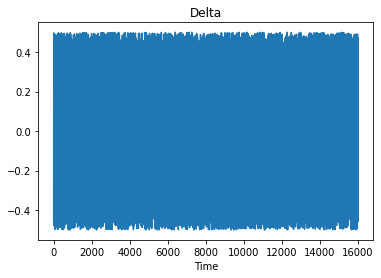

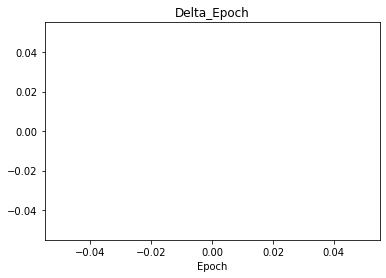

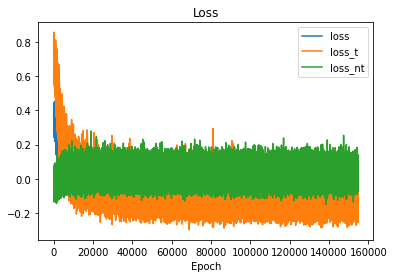

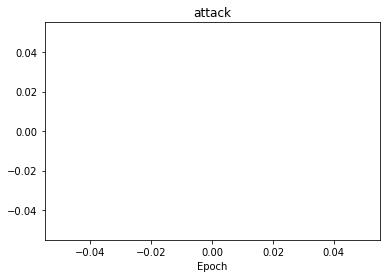

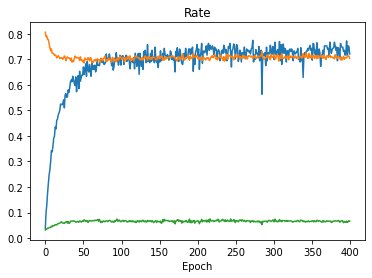

tensor([[-0.0840, -0.0201,  0.0491,  ..., -0.0454, -0.0090, -0.0459]],
       grad_fn=<SqueezeBackward1>)


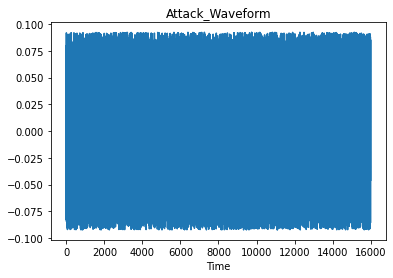

TypeError: test_attack() got an unexpected keyword argument 'delta'

In [23]:

time_ = time.strftime('%m_%d_%H_%M_%S',time.localtime(time.time()))
dir_path = os.path.join('output',time_)
os.mkdir(os.path.join('output',time_)) 

print(delta)
plt.plot(delta.squeeze().detach().to('cpu').numpy())
plt.xlabel("Time")
plt.title("Delta")
plt.savefig(os.path.join(dir_path,"Delta.png"), facecolor ="w" , edgecolor = "w") 
plt.show()
plt.close()
plt.plot(delta_sum)
plt.xlabel("Epoch")
plt.title("Delta_Epoch")
plt.savefig(os.path.join(dir_path,"Delta_Epoch.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
plt.plot(losses, label='loss')
plt.plot(losses_t, label='loss_t')
plt.plot(losses_nt, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss")
plt.savefig(os.path.join(dir_path,"Loss.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()


plt.plot(delta_wav)
plt.xlabel("Epoch")
plt.title("attack")
plt.savefig(os.path.join(dir_path,"Attack.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
plt.plot(attack_,label='attack')
plt.plot(maintain_,label='maintain')
plt.plot(error_,label='error')
plt.xlabel("Epoch")
plt.title("Rate")
plt.savefig(os.path.join(dir_path,"Rate.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
threshold = 0.2 + (n_epoch // threshold_epoch  -1 ) * 0.07

delta_ = threshold*torch.tanh(delta)
delta_ = delta_.to('cpu')
delta_ = torch.squeeze(delta_,0)

print(delta_)
plt.plot(torch.squeeze(delta_,0).detach().numpy())
plt.xlabel("Time")
plt.title("Attack_Waveform")
plt.savefig(os.path.join(dir_path,"Attack_Waveform.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
torchaudio.save(os.path.join(dir_path,"Attack.wav"), delta_ , sample_rate=16000, channels_first=True)


test_attack(model,0,threshold_epoch, model2,wav_save = True)

f = open(os.path.join(dir_path,"Parameter_2.txt"), "w")  # 打开文件
print("n_epoch=",n_epoch,file=f)
print("threshold_epoch=",threshold_epoch,file=f)
print("target:origin=1:0.5",file=f)

f.close()


In [ ]:
#test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)
test_attack(model,0,threshold_epoch, model2)

In [ ]:
print(len(attack_train_loader))

Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




Conclusion
----------

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


